In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%config InlineBackend.figure_format = 'retina'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from model import *
import sys 
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from torch.optim.lr_scheduler import StepLR
from loss_function import *

In [4]:
data_model = diffusion_equation()
dataset = data_model.generate_training_data(500, 10, dlt_t = 0.001)

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import Adam

data_loader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define a simple model with a single trainable parameter `k`
class SimpleModel(nn.Module):
    def __init__(self, k_value = None):
        super(SimpleModel, self).__init__()
        if k_value is None:
            self.k = nn.Parameter(torch.randn((), dtype=torch.float64))
        else:
            self.k = nn.Parameter(torch.tensor(k_value, dtype=torch.float64))  # Initialize k as a parameter

    def forward(self, lace_1, lace_2):
        g = lace_1
        h = self.k * lace_1 + lace_2
        return g, h

model = SimpleModel()

In [6]:
data_loader = DataLoader(dataset, batch_size=18000, shuffle=True)
for batch in data_loader:
    x, y, lace_1, lace_2 = batch
    break

In [7]:
lambda_1, lambda_2 = 0, 1
def loss_function(y, g, h):
    N = h.shape[0]
    loss_1 = terminal_loss_ver2(g, h, y)
    loss_2 = orthogonal_loss_ver2(g, h)
    return lambda_1 * loss_1 + lambda_2 * loss_2, loss_1, loss_2

def train_one_epoch(model, optimizer, scheduler, train_loader, loss_fn, epoch, writer):
    model.train()  # Set model to training mode
    total_loss = 0.0

    # Iterate over batches
    for batch_idx, batch in enumerate(train_loader):
        optimizer.zero_grad()  # Clear gradients

        x, y, lace_1, lace_2 = batch

        # Compute g and h using your model. This is model-specific and might look different.
        g, h = model(lace_1, lace_2)

        # Compute the custom loss
        loss = loss_fn(y - x, g, h)[0]

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        if batch_idx % 10 == 0:
            writer.add_scalar('Batch Loss', loss.item(), epoch * len(train_loader) + batch_idx)

        # Track gradients
        for name, param in model.named_parameters():
            if param.grad is not None:
                writer.add_histogram(f'{name}.grad', param.grad, epoch)

    scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Training Epoch: {epoch + 1}, Average Loss: {avg_loss:.4e}")
    writer.add_scalar('Training Loss', avg_loss, epoch)
    return avg_loss


In [8]:
g = lace_1
h = lace_2

In [9]:
# g, h = model(lace_1, lace_2)
# x = x.reshape(-1, 1)
# y = y.reshape(-1, 1)
# g = g.reshape(-1, 1)
# h = h.reshape(-1, 1)
# gh = torch.cat([g, h], dim=1)
# q, _ = torch.linalg.qr(gh)
# print(gh.shape)
# print(q.shape)

In [10]:
# import matplotlib.pyplot as plt
# plt.hist(lace_1.numpy().flatten(), bins=100)

In [11]:
# epsilon = 1e-6
# plt.hist(epsilon * lace_1.numpy().flatten(), bins=100)

In [12]:
# print(model.k)
# print(loss_function(y, g, h))

In [13]:
# k = 1
# epsilon = 1e-7
# h = lace_1
# g_1 = lace_1 + k * lace_2
# g_2 = lace_1 + (k + epsilon) * lace_2
# N = h.shape[0]
# h_orthogonal = h / (torch.dot(h.squeeze(), h.squeeze())/N + 1e-4)
# print(h_orthogonal)
# # print(g_1 * h)
# print(g_1 * h_orthogonal - g_2 * h_orthogonal)
# e_1 = orthogonal_loss(g_1, h_orthogonal)
# e_2 = orthogonal_loss(g_2, h_orthogonal)
# print(e_1, e_2)
# print(e_2 - e_1)

In [14]:
# Define the range of k values to explore
k_values = np.linspace(-4, 4, 100)
terminal_losses = []
orthogonal_losses = []
k_grads = []
k_grads_forward = []
epsilon = 1e-6

# Iterate over k values and compute the loss
for k in k_values:
    # print(k)
    model = SimpleModel(k)
    g, h = model(lace_1, lace_2)
    
    loss, loss_1, loss_2 = loss_function(y - x, g, h)
    terminal_losses.append(loss_1.item())
    orthogonal_losses.append(loss_2.item())
    model.zero_grad()
    loss.backward()
    
    k_grad = model.k.grad.item()
    k_grads.append(k_grad)

    # # Compute the gradient using finite differences
    # model_plus = SimpleModel(k + epsilon)
    # g_plus, h_plus = model_plus(lace_1, lace_2)
    # loss_plus, _, _ = loss_function(y, g_plus, h_plus)
    # # print(loss_plus.item())
    # model_minus = SimpleModel(k - epsilon)
    # g_minus, h_minus = model_minus(lace_1, lace_2)
    # loss_minus, _, _ = loss_function(y, g_minus, h_minus)
    # # print(loss_minus.item())
    # k_grad_forward = (loss_plus.item() - loss_minus.item()) / (2 * epsilon)
    # k_grads_forward.append(k_grad_forward)
    # # # break






In [15]:
print(terminal_losses)

[3.336387869758416e-16, 3.3369852926840265e-16, 3.3368730608185153e-16, 3.402726960791781e-16, 3.402507526318883e-16, 3.3363142837711235e-16, 3.404097830677353e-16, 3.336292313854054e-16, 3.336208934048309e-16, 3.336399781159237e-16, 3.3363007841835267e-16, 3.336739653129323e-16, 3.3361128487483546e-16, 3.3355958939527335e-16, 3.3359675296583413e-16, 3.3360059108387637e-16, 3.3361237013579913e-16, 3.336246256437547e-16, 3.3359894995754107e-16, 3.336292049156258e-16, 3.3360969668805936e-16, 3.33619755204308e-16, 3.336053291744251e-16, 3.3360763204525043e-16, 3.4049056883507967e-16, 3.3361724057524584e-16, 3.3364701907729775e-16, 3.3359275602911427e-16, 3.336226404102846e-16, 3.402383912448143e-16, 3.3361906699003836e-16, 3.33585529779283e-16, 3.336193316878344e-16, 3.335756565514916e-16, 3.3360636149582954e-16, 3.336013057679256e-16, 3.4053392633406725e-16, 3.336412486653446e-16, 3.3360318512227734e-16, 3.336091143529081e-16, 3.4018950156188997e-16, 3.3360202045197487e-16, 3.33628463761

In [16]:
print(orthogonal_losses)

[0.9502863883972168, 0.9479287266731262, 0.9454022645950317, 0.9426904320716858, 0.9397766590118408, 0.936639666557312, 0.933257520198822, 0.9296043515205383, 0.9256504774093628, 0.9213643670082092, 0.9167090654373169, 0.9116417169570923, 0.906113862991333, 0.9000702500343323, 0.8934487104415894, 0.886176586151123, 0.8781701326370239, 0.8693323731422424, 0.8595520853996277, 0.848701536655426, 0.8366281986236572, 0.8231608271598816, 0.8080956339836121, 0.791197657585144, 0.7721983790397644, 0.7507832646369934, 0.7265978455543518, 0.6992394924163818, 0.6682620048522949, 0.6331879496574402, 0.593529462814331, 0.5488294363021851, 0.4987347722053528, 0.4431108832359314, 0.3822093605995178, 0.3168911039829254, 0.24888966977596283, 0.18104739487171173, 0.11740618199110031, 0.0629853755235672, 0.023110367357730865, 0.0023323276545852423, 0.0032506485003978014, 0.025747066363692284, 0.06702190637588501, 0.12241312116384506, 0.1865837723016739, 0.25457701086997986, 0.32244759798049927, 0.3874514

In [17]:
print(k_grads)

[-0.02820247784256935, -0.030195165425539017, -0.032376356422901154, -0.03476782515645027, -0.03739498183131218, -0.04028709977865219, -0.04347682744264603, -0.04700268805027008, -0.05090876668691635, -0.055245183408260345, -0.060071077197790146, -0.06545417010784149, -0.07147428393363953, -0.07822305709123611, -0.08580763638019562, -0.0943543016910553, -0.10401009023189545, -0.11494745314121246, -0.12736856937408447, -0.14150890707969666, -0.15764668583869934, -0.17610211670398712, -0.19724854826927185, -0.22151273488998413, -0.24937589466571808, -0.2813691198825836, -0.3180563449859619, -0.3599975109100342, -0.4076813757419586, -0.4614090025424957, -0.5210977792739868, -0.5859825015068054, -0.6541703343391418, -0.7220442295074463, -0.7835511565208435, -0.8295540809631348, -0.8476446866989136, -0.8230745792388916, -0.7415517568588257, -0.5941473841667175, -0.3831126093864441, -0.12561118602752686, 0.14808763563632965, 0.40274131298065186, 0.6089341044425964, 0.7507646679878235, 0.8271

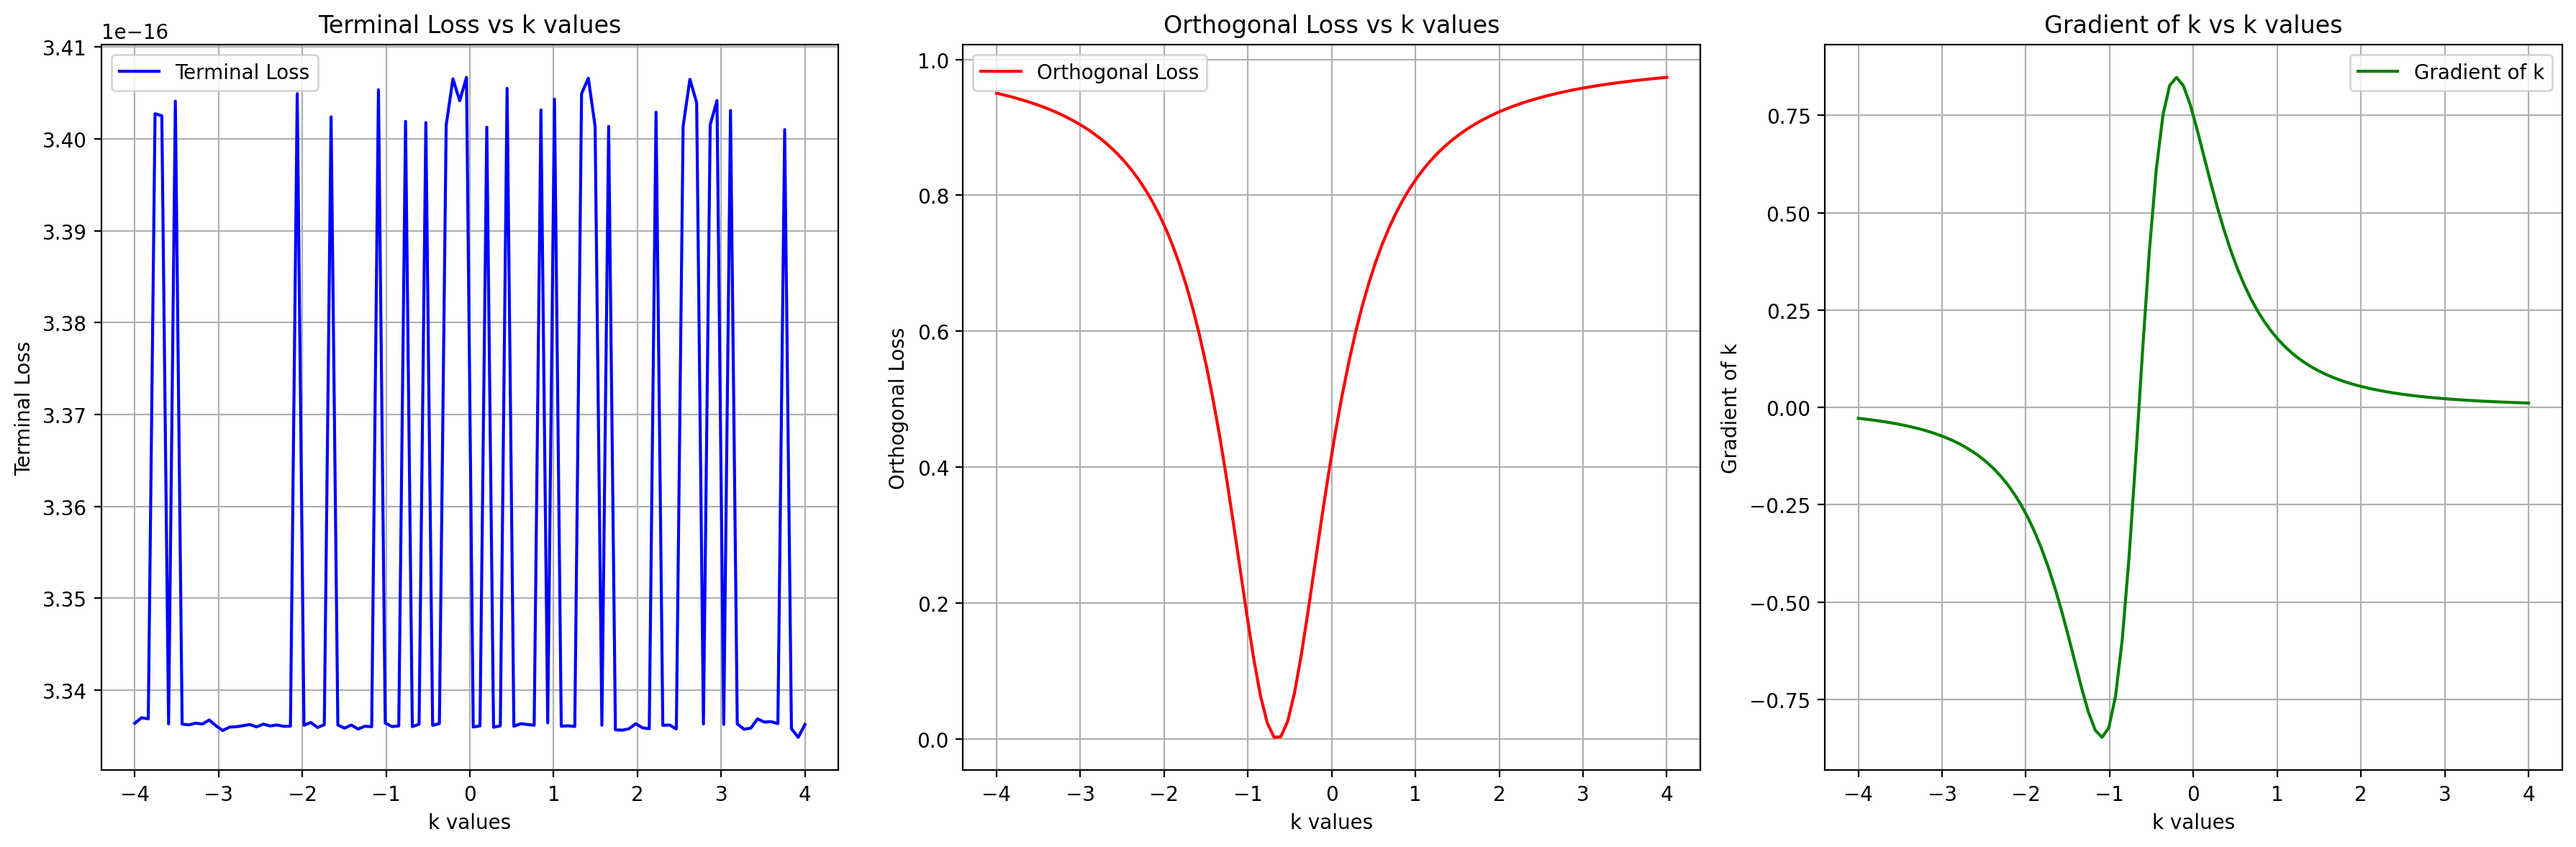

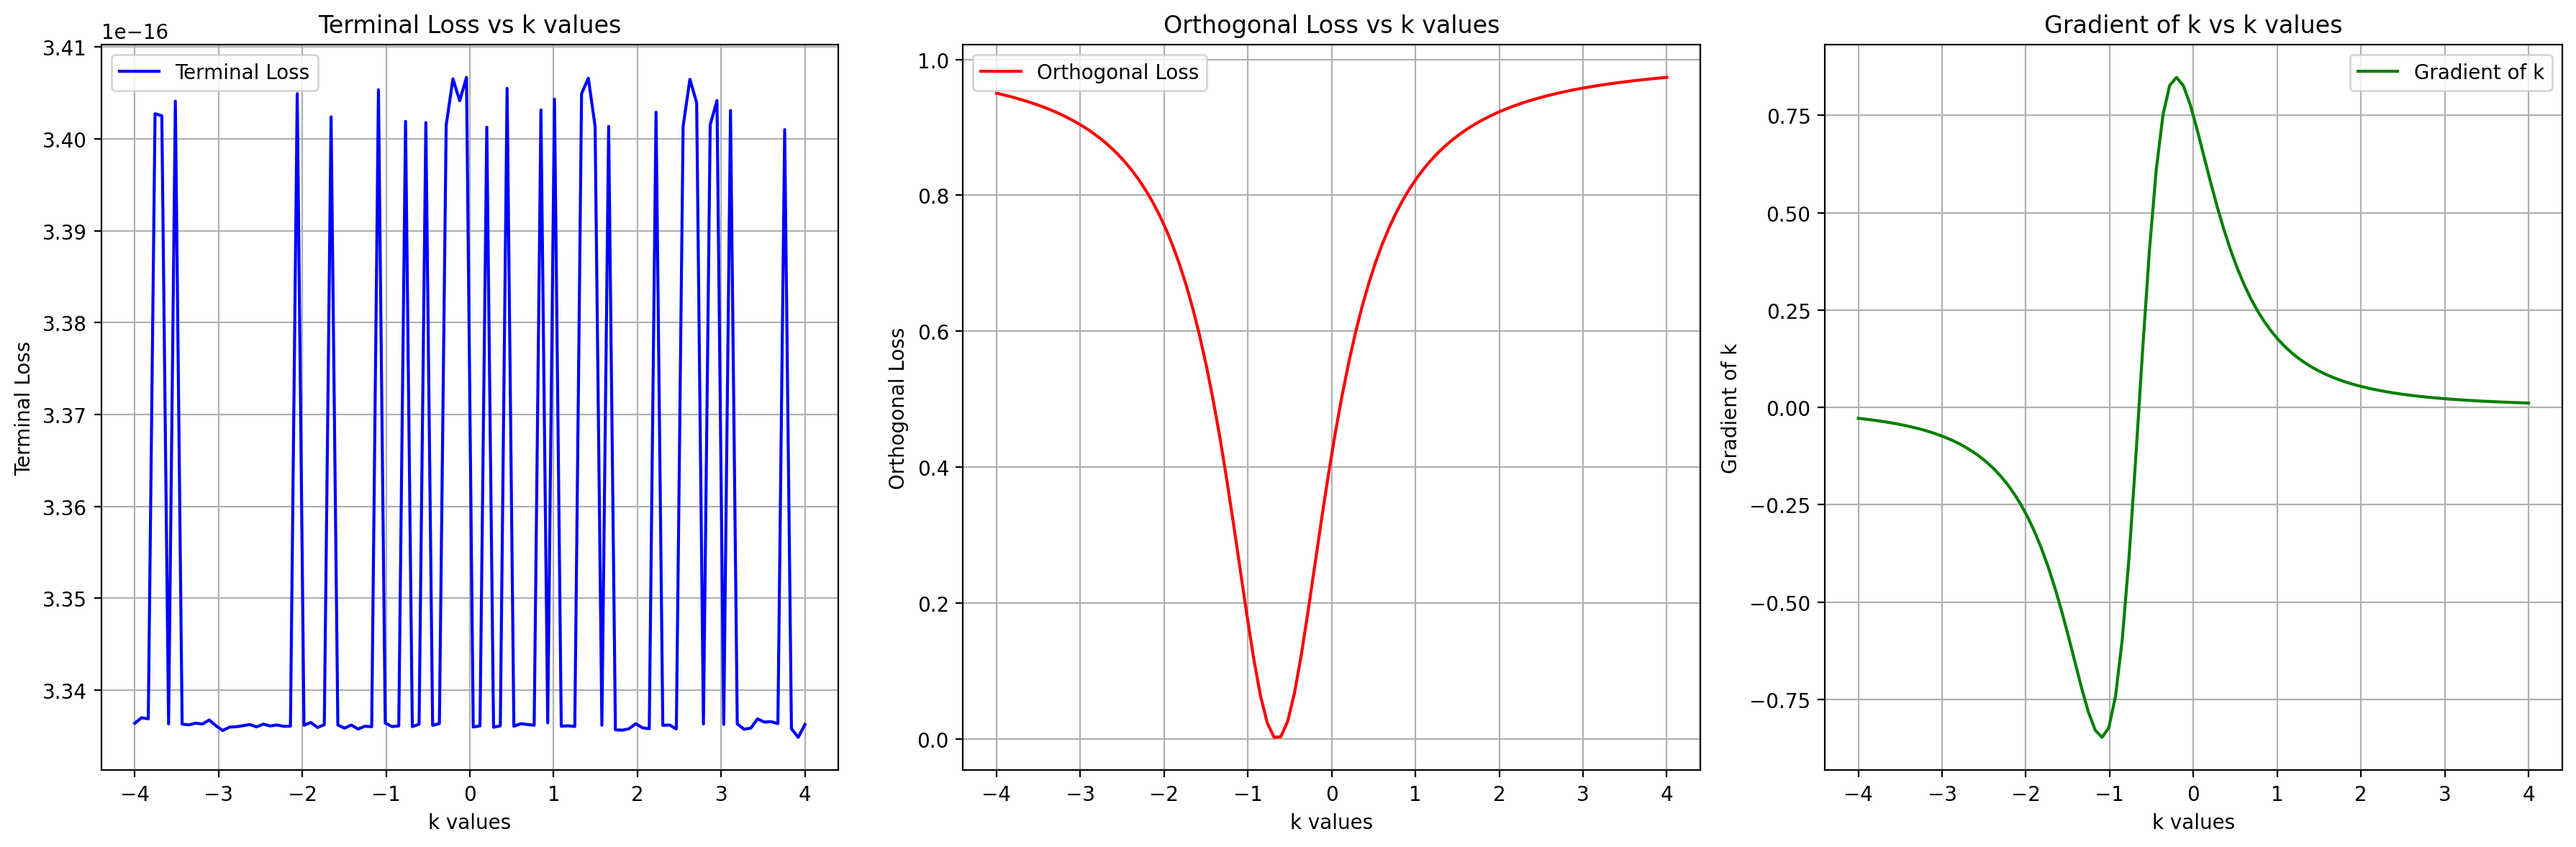

In [18]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
from IPython.display import display


# Terminal Loss

ax1.plot(k_values, terminal_losses, label='Terminal Loss', color='blue')
ax1.set_xlabel('k values')
ax1.set_ylabel('Terminal Loss')
ax1.set_title('Terminal Loss vs k values')
ax1.legend()
ax1.grid(True)

# Orthogonal Loss
ax2.plot(k_values, orthogonal_losses, label='Orthogonal Loss', color='red')
ax2.set_xlabel('k values')
ax2.set_ylabel('Orthogonal Loss')
ax2.set_title('Orthogonal Loss vs k values')
ax2.legend()
ax2.grid(True)

ax3.plot(k_values, k_grads, label='Gradient of k', color='green')
ax3.set_xlabel('k values')
ax3.set_ylabel('Gradient of k')
ax3.set_title('Gradient of k vs k values')
ax3.legend()
ax3.grid(True)


plt.tight_layout()
display(plt.gcf())

In [24]:
k = 0
model = SimpleModel(k)
g, h = model(lace_1, lace_2)
print(y)

# print(g.shape, h.shape)
print(g, h)
# print(lace_1, lace_2)

tensor([[0.2119],
        [0.8090],
        [0.1339],
        ...,
        [0.2318],
        [0.8942],
        [0.2132]])
tensor([[ 0.7809],
        [-0.4009],
        [ 1.0132],
        ...,
        [ 0.4085],
        [-1.2566],
        [-0.1131]]) tensor([[ 0.1723],
        [-0.5203],
        [ 0.2912],
        ...,
        [ 0.6795],
        [-1.4910],
        [ 0.8782]], grad_fn=<AddBackward0>)


In [25]:
# y = g + h
yy = torch.cat([x, g, h], dim=1)
print(yy)
y_orthogonal = gram_schmidt(yy)
coeffs, _, _, _ = torch.linalg.lstsq(y_orthogonal, y)
print(coeffs)

y_proj = torch.matmul(y_orthogonal, coeffs)
print(y_proj)
print(y)

tensor([[ 0.2110,  0.7809,  0.1723],
        [ 0.8100, -0.4009, -0.5203],
        [ 0.1326,  1.0132,  0.2912],
        ...,
        [ 0.2307,  0.4085,  0.6795],
        [ 0.8969, -1.2566, -1.4910],
        [ 0.2124, -0.1131,  0.8782]], grad_fn=<CatBackward0>)
tensor([[7.6753e+01],
        [1.3081e-01],
        [7.0197e-02]], grad_fn=<LinalgLstsqBackward0>)
tensor([[0.2119],
        [0.8090],
        [0.1339],
        ...,
        [0.2318],
        [0.8942],
        [0.2132]], grad_fn=<MmBackward0>)
tensor([[0.2119],
        [0.8090],
        [0.1339],
        ...,
        [0.2318],
        [0.8942],
        [0.2132]])


In [27]:
orthogonal_loss_ver2(g, h)

tensor(0.4189, grad_fn=<MaxBackward1>)